C:\Users\nickc\AppData\Local\Temp\ipykernel_14452\1398995413.py:14: DeprecationWarning: the argument `dtypes` for `read_csv` is deprecated. It was renamed to `schema_overrides` in version 0.20.31.
  df = pl.read_csv(


shape: (32_424, 5)
┌────────┬──────┬──────┬─────┬─────┐
│ t      ┆ i    ┆ j    ┆ Si  ┆ Sj  │
│ ---    ┆ ---  ┆ ---  ┆ --- ┆ --- │
│ i64    ┆ i64  ┆ i64  ┆ str ┆ str │
╞════════╪══════╪══════╪═════╪═════╡
│ 140    ┆ 1157 ┆ 1232 ┆ MED ┆ ADM │
│ 160    ┆ 1157 ┆ 1191 ┆ MED ┆ MED │
│ 500    ┆ 1157 ┆ 1159 ┆ MED ┆ MED │
│ 520    ┆ 1157 ┆ 1159 ┆ MED ┆ MED │
│ 560    ┆ 1159 ┆ 1191 ┆ MED ┆ MED │
│ …      ┆ …    ┆ …    ┆ …   ┆ …   │
│ 347600 ┆ 1295 ┆ 1629 ┆ NUR ┆ NUR │
│ 347600 ┆ 1383 ┆ 1629 ┆ PAT ┆ NUR │
│ 347620 ┆ 1232 ┆ 1295 ┆ ADM ┆ NUR │
│ 347620 ┆ 1383 ┆ 1629 ┆ PAT ┆ NUR │
│ 347640 ┆ 1295 ┆ 1629 ┆ NUR ┆ NUR │
└────────┴──────┴──────┴─────┴─────┘
Top 10 by Betweenness Centrality (with role):
Node 1098 (ADM): 0.0404
Node 1193 (NUR): 0.0352
Node 1164 (NUR): 0.0313
Node 1115 (NUR): 0.0287
Node 1109 (NUR): 0.0278
Node 1295 (NUR): 0.0268
Node 1210 (NUR): 0.0264
Node 1658 (ADM): 0.0227
Node 1190 (NUR): 0.0222
Node 1157 (MED): 0.0217

Top 10 by Degree Centrality (with role):
Node 1098 (ADM): 0.8243


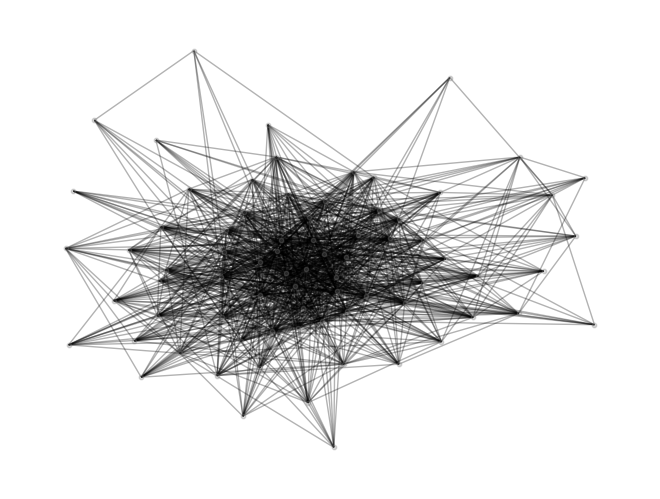

In [8]:
# import necessary packages
import numpy as np
import networkx as nx
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd


# create a table given hospital data that has: t  i  j  Si  Sj as a "header" 
# from website: "Each line has the form “t i j Si Sj“, where i and j are the anonymous IDs of the persons in contact, 
# Si and Sj are their statuses (NUR=paramedical staff, i.e. nurses and nurses’ aides; PAT=Patient; MED=Medical doctor; ADM=administrative staff), 
# and the interval during which this contact was active is [ t – 20s, t ]."

df = pl.read_csv(
    "detailed_list_of_contacts_Hospital.dat",
    separator="\t",
    has_header=False,
    new_columns=["t","i","j","Si","Sj"],
    dtypes={"t": pl.Int64, "i": pl.Int64, "j": pl.Int64, "Si": pl.Utf8, "Sj": pl.Utf8}
    # pl.Int64 = this column contains ints of 64 bits
    # pl.Utf8 = this column contains text/string values
)

# visualize network: this is an undirected graph that shows if person i and person j were ever in physical proximity with each other 
G = nx.from_pandas_edgelist(df, source='i', target='j') # i and j are anonymous ID's that were in contact with each other

nx.draw(G, node_size=10, node_color="gray", alpha=0.3)

print(df)



# STATS

# add roles to nodes as attributes
for row in df.iter_rows(named=True):
    G.nodes[row['i']]['role'] = row['Si']
    G.nodes[row['j']]['role'] = row['Sj']
    
bc = nx.betweenness_centrality(G)
dc = nx.degree_centrality(G)
ec = nx.eigenvector_centrality(G)

bc_sorted = sorted(bc.items(), key=lambda x: x[1], reverse=True)
dc_sorted = sorted(dc.items(), key=lambda x: x[1], reverse=True)
ec_sorted = sorted(ec.items(), key=lambda x: x[1], reverse=True)

# betweenness centrality: people who lie on the shortest paths between others (key bridges for transmission)
print("Top 10 by Betweenness Centrality (with role):")
for node, val in bc_sorted[:10]:
    role = G.nodes[node].get('role', 'Unknown')
    print(f"Node {node} ({role}): {val:.4f}")

# degree centrality: people who had the most direct physical contacts/highest number of unique people interacted with
print("\nTop 10 by Degree Centrality (with role):")
for node, val in dc_sorted[:10]:
    role = G.nodes[node].get('role', 'Unknown')
    print(f"Node {node} ({role}): {val:.4f}")

# eigenvector centrality: people who are connected to already well-connected people
print("\nTop 10 by Eigenvector Centrality (with role):")
for node, val in ec_sorted[:10]:
    role = G.nodes[node].get('role', 'Unknown')
    print(f"Node {node} ({role}): {val:.4f}")






NOTES:
Larger nodes in the network plot are individuals with many unique contacts, so they should have high opportunity to spread infection.
Orange, red and green nodes (staff) that are both large and central are plausible 'super spreaders' connecting the most patients.


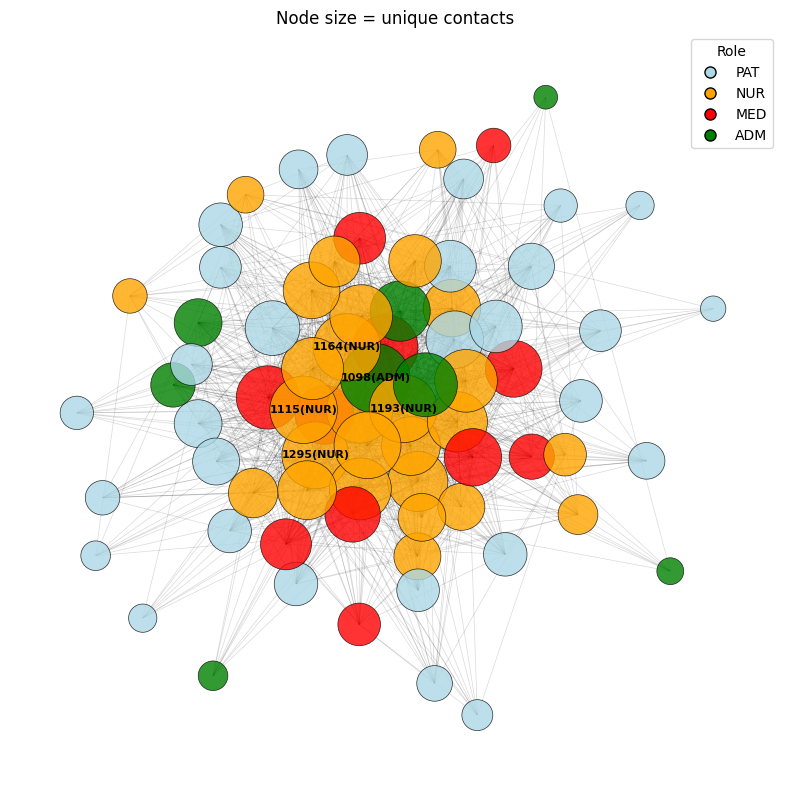

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import math
from matplotlib.lines import Line2D

deg_cent = nx.degree_centrality(G) # maps node to fraction of nodes directly contacted 
eig_cent = nx.eigenvector_centrality_numpy(G)  #maps node based on centrality

# assemble a per-node table of attributes for convenience  # comment
node_rows = []  #will become a list of dict one per hospital individual
for n in G.nodes():  # iterate through each node
    role = G.nodes[n].get("role","UNK")  # UNK is fallback
    node_rows.append({  # store this node
        "node": n,  # anonymous ID in dataset
        "role": role, #role
        "degree_centrality": deg_cent.get(n,0),  #how many unique contacts
        "eigenvector_centrality": eig_cent.get(n,0),  #influence in network core
    })

node_df = pd.DataFrame(node_rows) # turn list of dicts into a table
# Color each node by role
role_color_map = {
    "PAT":"lightblue",
    "NUR":"orange",
    "MED":"red",
    "ADM":"green",
    "UNK":"gray",
}

node_colors = []  # list of node colors in G.nodes() order  # comment
node_sizes = []  # list of node sizes in G.nodes() order  # comment
for n in G.nodes():  # build parallel lists for plotting  # comment
    role = G.nodes[n].get("role","UNK")  # role for color  # comment
    node_colors.append(role_color_map.get(role,"gray"))  # append color for this node  # comment
    size_val = deg_cent.get(n,0)  # degree centrality value for scaling  # comment
    node_sizes.append(3000 * size_val + 50)  # make hubs big but keep low nodes visible  # comment

pos = nx.spring_layout(G,weight=None,seed=7,k=5,iterations=200)  # more repulsion so nodes don't overlap as mcuh
plt.figure(figsize=(8,8))  # new figure
nx.draw_networkx_edges(G,pos,alpha=0.15,width=0.5) 

# draw nodes next, colored by role, sized by reach
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=node_colors,  
    node_size=node_sizes, 
    alpha=0.8,  # slight transparency
    linewidths=0.5, 
    edgecolors="black", 
)

# label top 5 most connected individuals to highlight likely transmission
top5 = sorted(deg_cent.items(),key=lambda x: x[1],reverse=True)[:5]  # pick 5 highest degree centrality nodes
for n,val in top5: # annotate 
    x,y = pos[n]  #get node coordinates
    label_txt = f"{n}({G.nodes[n].get('role','UNK')})"  # label shows ID and role
    plt.text(x,y,label_txt,fontsize=8,fontweight="bold",ha="center",va="center")  # draw label
    
legend_handles = [ 
    Line2D([0],[0],marker="o",color="w",markerfacecolor="lightblue",markeredgecolor="black",markersize=8,label="PAT"),  #patients 
    Line2D([0],[0],marker="o",color="w",markerfacecolor="orange",markeredgecolor="black",markersize=8,label="NUR"),  #nurses
    Line2D([0],[0],marker="o",color="w",markerfacecolor="red",markeredgecolor="black",markersize=8,label="MED"),  #doctors 
    Line2D([0],[0],marker="o",color="w",markerfacecolor="green",markeredgecolor="black",markersize=8,label="ADM"),  #admin
]

plt.legend(handles=legend_handles,loc="upper right",title="Role") # show legend
plt.title("Node size = unique contacts")
plt.axis("off")  # hide axes
plt.tight_layout()  #clean layout
print("\nNOTES:")
print("Larger nodes in the network plot are individuals with many unique contacts, so they should have high opportunity to spread infection.")
print("Orange, red and green nodes (staff) that are both large and central are plausible 'super spreaders' connecting the most patients.")

In [10]:
!pip install EoN
#need to install EoN its not in our virtual environment yet

In [11]:
import EoN
import numpy as np

# Transmission time function — must return an iterable to work (like a list)
def trans_time_fxn(u, v, rec_delay, tau):
    # Draw one random transmission delay
    delay = np.random.gamma(shape=2, scale=1/tau) # Gamma allows variability; shape=2 skews delays so most happen quickly
    # Modify slightly by infection duration memory
    delay *= (1 + 0.2 * np.tanh(rec_delay)) # longer infection increases delay
    return [delay]  # return as a list so it's iterable

# Recovery time function (can change recovery time based on which disease we choose -- will just change numbers)
def recov_time_fxn(u, gamma): # Draw recovery time from a lognormal distribution
                              # Ensures positive times and allows variability in recovery duration
    return np.random.lognormal(mean=np.log(1/gamma), sigma=0.5) # mean=np.log(1/gamma) gives expected recovery time ~ 1/gamma

# Parameters
tau = 0.02   # Base transmission rate (higher = faster spread)
gamma = 0.1  # Base recovery rate (higher = faster recovery), both tau and gamma can change based on which diease we do

# Pick a random initial infected (doing a nurse in this model)
initial_infecteds = [n for n, d in G.nodes(data=True) if d.get('role') == 'NUR'] # Select all nurse nodes in the network
initial_infecteds = list(np.random.choice(initial_infecteds, 1, replace=False)) # Randomly pick one nurse to start the infection

# Run simulation
sim = EoN.fast_nonMarkov_SIS(
    G,                            # Network graph of contacts
    trans_time_fxn=trans_time_fxn,# Transmission delay function
    rec_time_fxn=recov_time_fxn,  # Recovery time function
    trans_time_args=(tau,),       # Extra argument(s) for trans_time_fxn
    rec_time_args=(gamma,),       # Extra argument(s) for recov_time_fxn
    initial_infecteds=initial_infecteds, # Start with one infected node
    tmax=2000,                    # Maximum simulation time
    return_full_data=True          # Return Simulation_Investigation object
)

# Extract time series from the Simulation_Investigation object
t = sim.t() # Array of the time points
S = sim.S() # Number of susceptible nodes at each time point
I = sim.I() # Number of infected nodes at each time point
print("This code runs a non-Markovian SIS epidemic simulation on the network G, using custom functions for how long infections and recoveries take.")
print("(We can change the tau and gamma parameters when we get the actual data we are working with, based on which disease, etc.)")
print("It returns time-series data showing how the number of susceptible (S) and infected (I) nodes changes over time (t).")


This code runs a non-Markovian SIS epidemic simulation on the network G, using custom functions for how long infections and recoveries take.
(We can change the tau and gamma parameters when we get the actual data we are working with, based on which disease, etc.)
It returns time-series data showing how the number of susceptible (S) and infected (I) nodes changes over time (t).


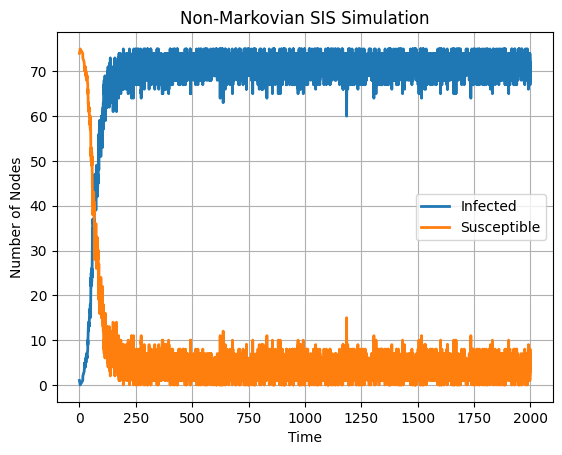

This chunk creates a graph of the epidemic curve, showing how infections rise and fall throughout the simulation.
 visualizes dynamics -- can see when infected is high the number of susceptible is low


In [12]:
import matplotlib.pyplot as plt

plt.plot(t, I, label='Infected', lw=2)
plt.plot(t, S, label='Susceptible', lw=2) #plots infected against susceptible for number of nodes over time (I vs S)
plt.xlabel('Time')
plt.ylabel('Number of Nodes')
plt.title('Non-Markovian SIS Simulation')
plt.legend()
plt.grid(True) #makes a grid to see it easier
plt.show()
print("This chunk creates a graph of the epidemic curve, showing how infections rise and fall throughout the simulation.")
print(" visualizes dynamics -- can see when infected is high the number of susceptible is low")

In [13]:
peak_infected = np.max(I) #number of people infected at peak
time_of_peak = t[np.argmax(I)] #gives the time that peak infection occured
end_prevalence = I[-1] / (S[-1] + I[-1]) #the amount of people that were infected (in percent) out of the network
print(f"Peak infected: {peak_infected} at time {time_of_peak:.2f}")
print(f"Final prevalence: {end_prevalence:.3f}")
print("This computes key epidemic statistics: the highest number of infections, when that peak occurred, and how many remained infected at the end.")
print("It gives a quick numerical summary of how severe and persistent the outbreak was.")

Peak infected: 75 at time 194.67
Final prevalence: 0.960
This computes key epidemic statistics: the highest number of infections, when that peak occurred, and how many remained infected at the end.
It gives a quick numerical summary of how severe and persistent the outbreak was.


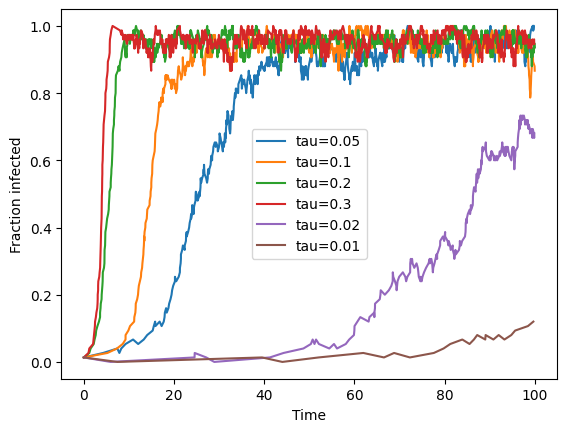

This section reruns the simulation with different transmission rates (tau) to see how infection speed affects the outcome.
It lets you visually compare multiple scenarios on one plot to understand parameter sensitivity.


In [14]:
taus = [0.05, 0.1, 0.2, 0.3, 0.02, 0.01]
for tau in taus:
    t, S, I = EoN.fast_nonMarkov_SIS(G, trans_time_fxn, recov_time_fxn, #loops through and graphs through each tau above
                                     trans_time_args=(tau,), #tau changes
                                     rec_time_args=(gamma,), #gamma stays the same
                                     initial_infecteds=initial_infecteds) #number that is infected at first (one nurse was chosen in above code)
    plt.plot(t, [i/len(G) for i in I], label=f'tau={tau}')
plt.xlabel('Time')
plt.ylabel('Fraction infected')
plt.legend()
plt.show()
print("This section reruns the simulation with different transmission rates (tau) to see how infection speed affects the outcome.")
print("It lets you visually compare multiple scenarios on one plot to understand parameter sensitivity.")

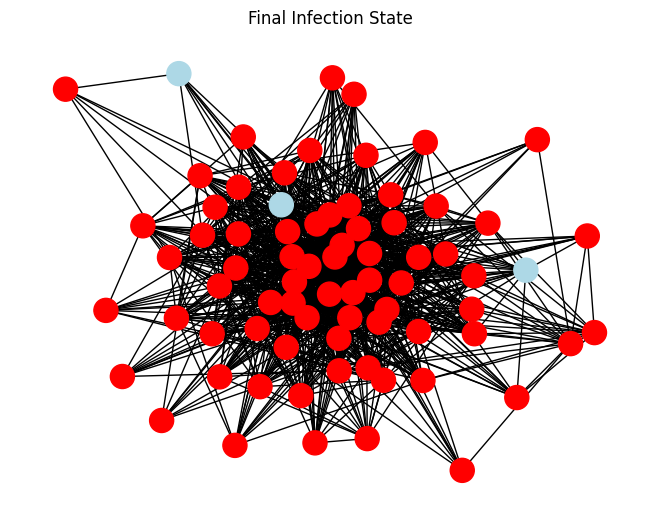

In [15]:
infected_nodes = sim.get_statuses(time=max(sim.t())) #status of simulation at the end of it (max)
infected_nodes = {n for n, status in infected_nodes.items() if status == 'I'} #infected if I
nx.draw(G, node_color=['red' if n in infected_nodes else 'lightblue' for n in G.nodes()]) #red if infected, light blue if not
plt.title("Final Infection State")
plt.show()

Outbreak reaches a high endemic level because the system finds a stable equilibrium quickly. Will need to include fluctuations most likely for the actual data that we simulate / plot for the project. Some mechanisms that could be used for this:
* Run multiple simualtions to see if they differ (tried that with this data and it didn't really change anything)
* Make transmission or recovery time-varying (seasonal / periodic forcing)
* Introduce admissions/discharges (node turnover) -- like people dying or being admitted/discharged from the hospital
* Add heterogeneity / superspreaders - make transmission rates node-specific or heavy-tailed (some nodes have very high tau). Cdiff for example can have varying transmission rates based on the person -

